## **Forecasting Daily Electricity Demand in ERCOT Using Historical Temperature Data**
### **By:** Mariah N Cornelio

The goal of this project is to predict total daily electricity demand for the ERCOT grid based on historical weather (Dallas temperature), showing how temperature drives demand and demonstrating time-series forecasting skills.

**Note:** Dallas temperature is used as a proxy for the entire ERCOT region. While I know that this does not perfectly capture weather in West or South Texas and may introduce some noise, it is a reasonable approximation for population-weighted demand and is sufficient to demonstrate forecasting and infrastructure planning insights at the grid level

**Data Sources:**
- EIA: https://www.eia.gov/opendata/
- NOAA Weather: https://www.ncei.noaa.gov/cdo-web/datasets

### **OVERVIEW**
- **Part 1:** Import data using EIA API and NOAA weather databases
- **Part 2:** Prepare datasets
- **Part 3:** Merge ERCO and Dallas weather datasets
- **Part 4:** EDA and feature engineering on merged data
- **Part 5:** Baseline linear regression model with lag features for time-series
- **Part 6:** XGBoost model (nonlinear model)
- **Part 7:** Feature engineer and improve XGBoost model
- **Part 8:** Try Prophet
- **Part 9:** Extract data from final models (XGBoost baseline and Prophet)

**Import packages**

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from prophet import Prophet

### **Part 1: Import data using EIA API and NOAA weather databases**

In [2]:
# How to get the energy data
url = "https://api.eia.gov/v2/electricity/rto/daily-region-sub-ba-data/data/"
params = {
    "api_key": "APIkey", # For privacy purposes, my API key will be removed
    "frequency": "daily",
    "data[0]": "value",
    "facets[parent][]": "ERCO",
    "facets[timezone][]": "Central",
    "start": "2023-01-01",
    "end": "2026-02-08",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000} # Only 5k at a time can be requested so will need to make it rolling

all_data = []

while True:
    response = requests.get(url, params=params)
    data = response.json()["response"]["data"]
    
    if not data:
        break
    all_data.extend(data)
    params["offset"] += 5000
    print(f"Pulled {len(all_data)} rows so far...")

df = pd.DataFrame(all_data)

KeyError: 'response'

In [ ]:
# Save energy data 
df.to_csv("ercot_daily_demand.csv", index=False)

For the NOAA weather dataset GHCND (CSV) order, Dallas, TX was selected as the region and here are the details:
- **Locations:** CITY:US480016
- **Begin Date:** 2023-01-01 00:00
- **End Date:** 2026-02-08 23:59
- **Data Types:** PRCP, SNWD, SNOW, PSUN, TAVG, TMAX, TMIN, AWND, WT07, WT01, WT06, WT05, WT02, WT04, WT08, WT03
    - TAVG will be the main focus for this project
- **Units:** Standard
- **Custom Flag(s):** Station Name

### **Part 2: Prepare datasets**

**Import data**

In [3]:
ercot_daily = pd.read_csv("ercot_daily_demand.csv")
weather_df = pd.read_csv("dallas_weather.csv")

Upon inspection of the csv's, some data was missing so we will need to address that below.

**Prepare ERCO data**

In [4]:
ercot_daily.head()

,period,subba,subba-name,parent,parent-name,timezone,value,value-units
0,2026-02-08,EAST,East,ERCO,"Electric Reliability Council of Texas, Inc.",Central,36347,megawatthours
1,2026-02-08,NCEN,North Central,ERCO,"Electric Reliability Council of Texas, Inc.",Central,283609,megawatthours
2,2026-02-08,NRTH,North,ERCO,"Electric Reliability Council of Texas, Inc.",Central,43686,megawatthours
3,2026-02-08,SCEN,South Central,ERCO,"Electric Reliability Council of Texas, Inc.",Central,170130,megawatthours
4,2026-02-08,SOUT,South,ERCO,"Electric Reliability Council of Texas, Inc.",Central,84810,megawatthours


In [5]:
ercot_daily.shape

(8652, 8)

In [6]:
ercot_daily.dtypes

period         object
subba          object
subba-name     object
parent         object
parent-name    object
timezone       object
value           int64
value-units    object
dtype: object

Note that there are multiple rows for the same data due to the different subba's (subregions of Texas). We must aggregate by date first to combine subregions together. Dallas will be used as a proxy (since it is a major city) to represent ERCO infrastructure demands.

In [7]:
# Ensure correct dtype
ercot_daily["period"] = pd.to_datetime(ercot_daily["period"])

In [8]:
# Aggregate by date
ercot_daily_total = (
    ercot_daily.groupby("period")["value"]
    .sum()
    .reset_index()
    .rename(columns={"period": "date", "value": "demand_mwh"}))

In [9]:
ercot_daily_total.head() # Check tail to see quick range

,date,demand_mwh
0,2023-01-01,900387
1,2023-01-02,971904
2,2023-01-03,963741
3,2023-01-04,984015
4,2023-01-05,1012246


In [10]:
ercot_daily_total.shape

# Went from 8652 rows to 1088 (ranges January 1, 2023 to February 8, 2026)

(1088, 2)

In [11]:
# Save cleaned ercot daily total
ercot_daily_total.to_csv("ercot_daily_total.csv", index=False)

**Prepare Dallas weather**

In [12]:
weather_df.head()

,STATION,NAME,DATE,AWND,PRCP,PSUN,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08
0,US1TXDA0065,"GARLAND 3.6 NNW, TX US",2023-01-01,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1TXDA0065,"GARLAND 3.6 NNW, TX US",2023-01-02,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1TXDA0065,"GARLAND 3.6 NNW, TX US",2023-01-03,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1TXDA0065,"GARLAND 3.6 NNW, TX US",2023-01-04,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1TXDA0065,"GARLAND 3.6 NNW, TX US",2023-01-05,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These are the meaning of each column (taken from the GHCND documentation from NOAA): 
- AWND: Average daily wind speed (meters per second or miles per hour as per user preference)
- PRCP: Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
- PSUN: Daily percent of possible sunshine (percent)
- SNOW: Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)
- SNWD: Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)
- TAVG: Average temperature of the day
- TMAX: Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file)
- TMIN: Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file
- WT01: Fog, ice fog, or freezing fog (may include heavy fog)
- WT02: Heavy fog or heaving freezing fog (not always distinguished from fog)
- WT03: Thunder
- WT04: Ice pellets, sleet, snow pellets, or small hail
- WT05: Hail (may include small hail)
- WT06: Glaze or rime
- WT07: Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
- WT08: Smoke or haze 

In [13]:
weather_df.dtypes

STATION     object
NAME        object
DATE        object
AWND       float64
PRCP       float64
PSUN       float64
SNOW       float64
SNWD       float64
TAVG       float64
TMAX       float64
TMIN       float64
WT01       float64
WT02       float64
WT03       float64
WT04       float64
WT05       float64
WT06       float64
WT07       float64
WT08       float64
dtype: object

In [14]:
weather_df.shape

(20674, 19)

An important thing to note here is that these are different temp ranges (1/1/23 to 2/8/26) for different stations (Mesquite, Lancaster, Dallas, Rockwall, etc), hence why 20k rows. A lot of these places are missing TAVG and other important data but the one station that had mostly everything for this date range is DALLAS FAA AIRPORT, TX US (STATION: USW00013960). So we need to take data from that station and work from there to see if there is any missing data. By the end, the shape of this weather dataframe should ideally match the ercot_daily_total df with 1088 rows. 

In [15]:
# Keep only the Dallas FAA Airport station
weather_df = weather_df[weather_df["STATION"] == "USW00013960"]

In [16]:
weather_df["date"] = pd.to_datetime(weather_df["DATE"])

In [17]:
# Fill missing TAVG where possible
weather_df["TAVG"] = weather_df["TAVG"].fillna((weather_df["TMAX"] + weather_df["TMIN"])/2)

# Drop rows where TAVG is still missing
weather_df_clean = weather_df.dropna(subset=["TAVG"])

In [18]:
weather_df_clean.head()

,STATION,NAME,DATE,AWND,PRCP,PSUN,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,date
13331,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-01,8.72,0.0,NaN,0.0,0.0,66.0,77.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01
13332,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-02,8.50,0.0,NaN,0.0,0.0,69.0,78.0,64.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2023-01-02
13333,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-03,7.16,0.0,NaN,0.0,0.0,65.0,69.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03
13334,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-04,2.91,0.0,NaN,0.0,0.0,50.0,59.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-04
13335,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-05,3.58,0.0,NaN,0.0,0.0,48.0,62.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-05


In [19]:
weather_df_clean.shape

(1135, 20)

After checking, ercot_daily_total has some missing data (like the first 10 days of December 2025 but that's honestly okay).

In [20]:
# Save cleaned weather data 
weather_df_clean.to_csv("weather_df_clean.csv", index=False)

### **Part 3: Merge ERCO and Dallas weather datasets**

In [21]:
# Make sure data columns match
# ERCOT
ercot_daily_total["date"] = pd.to_datetime(ercot_daily_total["date"])
# Weather (already filtered to Dallas FAA)
weather_df_clean["date"] = pd.to_datetime(weather_df_clean["DATE"])

In [22]:
merged = pd.merge(
    ercot_daily_total,
    weather_df_clean,
    on="date",
    how="inner")   # keeps only dates present in both datasets

In [23]:
merged.head()

,date,demand_mwh,STATION,NAME,DATE,AWND,PRCP,PSUN,SNOW,SNWD,...,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08
0,2023-01-01,900387,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-01,8.72,0.0,NaN,0.0,0.0,...,77.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,971904,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-02,8.50,0.0,NaN,0.0,0.0,...,78.0,64.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2023-01-03,963741,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-03,7.16,0.0,NaN,0.0,0.0,...,69.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,984015,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-04,2.91,0.0,NaN,0.0,0.0,...,59.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,1012246,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-05,3.58,0.0,NaN,0.0,0.0,...,62.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
merged.shape # Matches ercot daily totals!

(1088, 21)

In [25]:
merged.isna().sum()

date             0
demand_mwh       0
STATION          0
NAME             0
DATE             0
AWND            12
PRCP             0
PSUN          1088
SNOW            12
SNWD           121
TAVG             0
TMAX             0
TMIN             0
WT01           845
WT02          1083
WT03           924
WT04          1085
WT05          1078
WT06          1083
WT07          1085
WT08          1012
dtype: int64

Fortunately for this dataset, it is reasonable to fill the missing values with 0. This is because for the weather types, it is a binary variable where 0 is if it didnt happen. And if there is no SNOW or SNWD data, it most likely means it did not snow that day. However for AWND, and PSUN; 0 will assume that there is no sun or no wind at all that day which may not be true. But note that all 1088 rows for PSUN are gone so we can safely remove that feature. So interpolation will just be used to fill in the missing data for the wind column. 

In [26]:
# Remove PSUN column since all values are missing
merged = merged.drop(columns=["PSUN"])

# Fill SNOW and SNWD missing values with 0 (reasonable assumption)
merged[["SNOW", "SNWD"]] = merged[["SNOW", "SNWD"]].fillna(0)

# Interpolate missing AWND (average wind speed)
merged["AWND"] = merged["AWND"].interpolate()

# Fill weather type flags with 0
wt_cols = ["WT01","WT02","WT03","WT04","WT05","WT06","WT07","WT08"]
merged[wt_cols] = merged[wt_cols].fillna(0)

In [27]:
merged.isnull().values.any() # No more null values

np.False_

In [28]:
# Save merged data 
merged.to_csv("merged.csv", index=False)

### **Part 4: EDA and feature engineering on merged data**

In [2]:
df = pd.read_csv("merged.csv")

In [3]:
df.head()

,date,demand_mwh,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08
0,2023-01-01,900387,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-01,8.72,0.0,0.0,0.0,66.0,77.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-02,971904,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-02,8.50,0.0,0.0,0.0,69.0,78.0,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023-01-03,963741,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-03,7.16,0.0,0.0,0.0,65.0,69.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-04,984015,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-04,2.91,0.0,0.0,0.0,50.0,59.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-05,1012246,USW00013960,"DALLAS FAA AIRPORT, TX US",2023-01-05,3.58,0.0,0.0,0.0,48.0,62.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

# There are 2 date columns
# We can remove one; we can also remove "STATION" since it is all the same (USW00013960) and the NAME since it is also all the same (DALLAS FAA AIRPORT, TX US)

Index(['date', 'demand_mwh', 'STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW',
       'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT07', 'WT08'],
      dtype='object')

In [5]:
df.dtypes

date           object
demand_mwh      int64
STATION        object
NAME           object
DATE           object
AWND          float64
PRCP          float64
SNOW          float64
SNWD          float64
TAVG          float64
TMAX          float64
TMIN          float64
WT01          float64
WT02          float64
WT03          float64
WT04          float64
WT05          float64
WT06          float64
WT07          float64
WT08          float64
dtype: object

In [6]:
# Drop duplicate and constant columns
df = df.drop(columns=["DATE", "STATION", "NAME"])

# Make sure date is datetime
df["date"] = pd.to_datetime(df["date"])

# Sort by date (important for time series)
df = df.sort_values("date").reset_index(drop=True)

In [7]:
df.columns

Index(['date', 'demand_mwh', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX',
       'TMIN', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1088 non-null   datetime64[ns]
 1   demand_mwh  1088 non-null   int64         
 2   AWND        1088 non-null   float64       
 3   PRCP        1088 non-null   float64       
 4   SNOW        1088 non-null   float64       
 5   SNWD        1088 non-null   float64       
 6   TAVG        1088 non-null   float64       
 7   TMAX        1088 non-null   float64       
 8   TMIN        1088 non-null   float64       
 9   WT01        1088 non-null   float64       
 10  WT02        1088 non-null   float64       
 11  WT03        1088 non-null   float64       
 12  WT04        1088 non-null   float64       
 13  WT05        1088 non-null   float64       
 14  WT06        1088 non-null   float64       
 15  WT07        1088 non-null   float64       
 16  WT08        1088 non-nul

In [9]:
df.describe()

,date,demand_mwh,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08
count,1088,1.088000e+03,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000
mean,2024-06-29 12:22:30,1.273039e+06,8.043010,0.113134,0.002482,0.003125,69.134651,79.188419,59.522978,0.223346,0.004596,0.150735,0.002757,0.009191,0.004596,0.002757,0.069853
min,2023-01-01 00:00:00,3.790180e+05,1.570000,0.000000,0.000000,0.000000,15.000000,21.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-09-29 18:00:00,1.098732e+06,5.820000,0.000000,0.000000,0.000000,58.000000,68.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-06-27 12:00:00,1.227660e+06,7.830000,0.000000,0.000000,0.000000,72.000000,82.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2025-03-26 06:00:00,1.463474e+06,9.840000,0.000000,0.000000,0.000000,82.000000,93.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2026-02-08 00:00:00,1.746060e+06,22.370000,4.220000,1.200000,1.200000,98.000000,110.000000,88.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,2.209121e+05,3.030698,0.376952,0.048371,0.059663,16.154612,16.405969,16.564763,0.416680,0.067666,0.357955,0.052462,0.095473,0.067666,0.052462,0.255016


**Visualize daily energy demand for 2023-2026 for ERCOT**

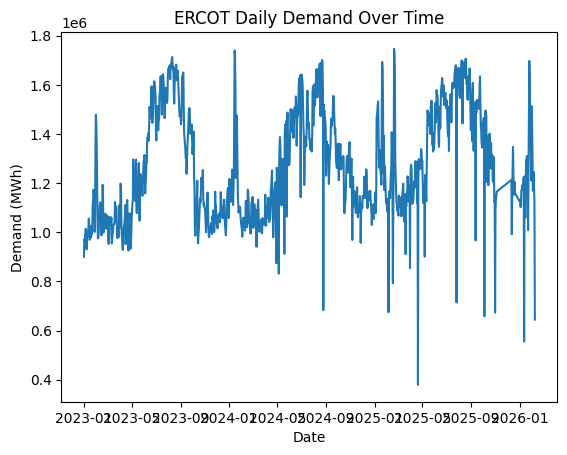

In [10]:
plt.figure()
plt.plot(df["date"], df["demand_mwh"])
plt.title("ERCOT Daily Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand (MWh)")
plt.show()

From this pattern, we can see that there are seasonal peaks and seasonal dips and some outliers in the data

**Visualize energy demand vs temperature for ERCOT**

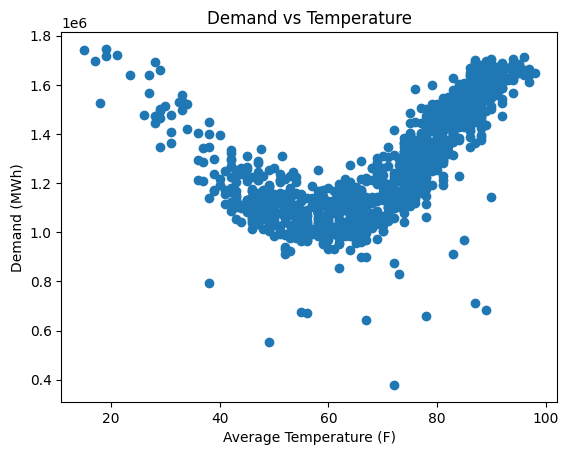

In [11]:
plt.figure()
plt.scatter(df["TAVG"], df["demand_mwh"])
plt.xlabel("Average Temperature (F)")
plt.ylabel("Demand (MWh)")
plt.title("Demand vs Temperature")
plt.show()

From this we see the most energy demand when the temperature is 20-30 and 75-100. We can see the outliers as well that deviate form the bowl-pattern.

**Feature engineering**

In [12]:
df["TAVG_squared"] = df["TAVG"]**2

# We will create this new feature for our model to demonstrate that electricity demand usually has a nonlinear relationship with temperature

In [13]:
# Add time features
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek
df["year"] = df["date"].dt.year

In [14]:
df.head()

,date,demand_mwh,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,...,WT03,WT04,WT05,WT06,WT07,WT08,TAVG_squared,month,day_of_week,year
0,2023-01-01,900387,8.72,0.0,0.0,0.0,66.0,77.0,55.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4356.0,1,6,2023
1,2023-01-02,971904,8.50,0.0,0.0,0.0,69.0,78.0,64.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4761.0,1,0,2023
2,2023-01-03,963741,7.16,0.0,0.0,0.0,65.0,69.0,46.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4225.0,1,1,2023
3,2023-01-04,984015,2.91,0.0,0.0,0.0,50.0,59.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,1,2,2023
4,2023-01-05,1012246,3.58,0.0,0.0,0.0,48.0,62.0,36.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2304.0,1,3,2023


We can quickly verify if these are true by comparing with a calendar. This coincides with Monday=0 and Sunday=6.

**Check energy demand by month**

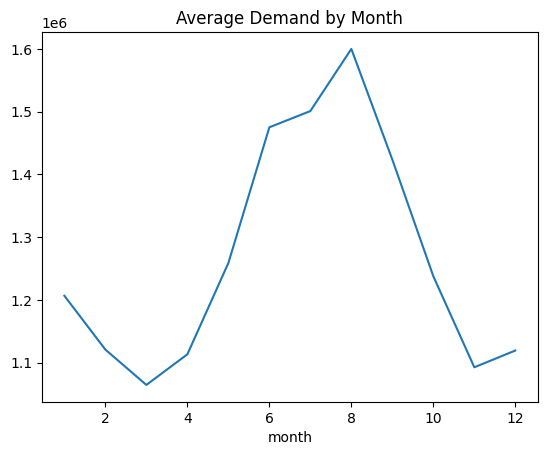

In [15]:
df.groupby("month")["demand_mwh"].mean().plot()
plt.title("Average Demand by Month")
plt.show()

Here we see that energy demands are the highest during summer months with peak being in August for Texas.

**Check correlation for multicollinearity**

In [16]:
df.corr(numeric_only=True)["demand_mwh"].sort_values(ascending=False) # This is set against energy demand

demand_mwh      1.000000
TAVG_squared    0.650719
TMIN            0.566908
TAVG            0.560649
TMAX            0.530364
month           0.208065
year            0.184658
SNOW            0.053916
SNWD            0.040052
WT04            0.035852
WT06            0.034496
WT05            0.006950
AWND           -0.009276
WT03           -0.019810
WT07           -0.030401
WT08           -0.035816
PRCP           -0.062530
WT02           -0.072926
day_of_week    -0.101825
WT01           -0.160755
Name: demand_mwh, dtype: float64

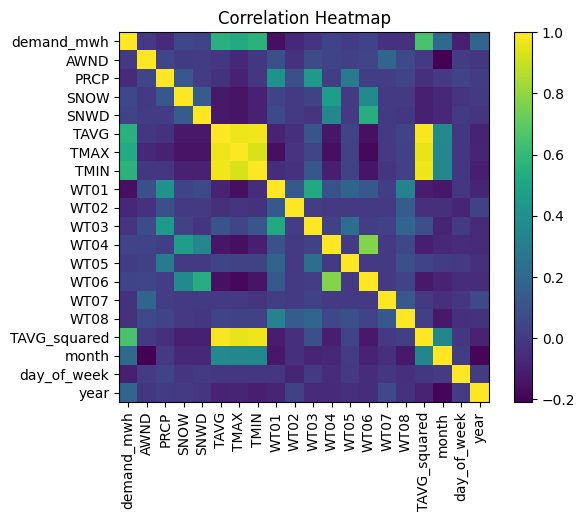

In [17]:
corr_matrix = df.corr(numeric_only=True)
plt.figure()
plt.imshow(corr_matrix)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
corr_matrix = df.corr(numeric_only=True)

# Flatten correlation matrix into a list
corr_pairs = (
    corr_matrix
    .unstack()
    .sort_values(ascending=False))

corr_pairs = corr_pairs[corr_pairs < 1] # Remove self-correlation
strong_corr = corr_pairs[abs(corr_pairs) > 0.8]
strong_corr

TAVG_squared  TAVG            0.989409
TAVG          TAVG_squared    0.989409
TMIN          TAVG            0.975210
TAVG          TMIN            0.975210
TMAX          TAVG            0.971644
TAVG          TMAX            0.971644
TMIN          TAVG_squared    0.968411
TAVG_squared  TMIN            0.968411
              TMAX            0.958617
TMAX          TAVG_squared    0.958617
TMIN          TMAX            0.924725
TMAX          TMIN            0.924725
dtype: float64

This confirms that there is serious multicollinearity in this data, specifically regarding temperature. For the model, it is wise to choose only one/two important features. We may keep the rest so that it can be visualized on the dashboard later but just **remember to manually remove multicollinearated features when building the model**.

In [19]:
# Check for multicollinearity using VIF
features = df[[
    "TAVG",
    "TMIN",
    "TMAX",
    "TAVG_squared",
    "AWND",
    "PRCP", "demand_mwh", "SNOW", "SNWD"]]

vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [
    variance_inflation_factor(features.values, i)
    for i in range(features.shape[1])]

vif_data # This confirms it

,feature,VIF
0,TAVG,1658.098031
1,TMIN,361.633397
2,TMAX,623.492515
3,TAVG_squared,73.193559
4,AWND,8.386983
5,PRCP,1.229103
6,demand_mwh,37.931158
7,SNOW,1.078642
8,SNWD,1.060526


In [20]:
df.columns

Index(['date', 'demand_mwh', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX',
       'TMIN', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08',
       'TAVG_squared', 'month', 'day_of_week', 'year'],
      dtype='object')

In [21]:
df.to_csv("merged_clean.csv", index=False)

### **Part 5: Baseline linear regression model with lag features for time-series**

Before beginning, we should understand the model first and the plan of action. Since this is a regression forecasting model, the best metric will be RMSE, MAE, and R^2. Usually, CV (cross-validation) would be good, but for this standard CV is not appropriate. This is because time-series is ordered by date and CV will randomly shuffle it (the model can accidentally train on future data and predict the past, which is data leakage). A better way to validate would be either rolling window validation or a time series split.

In [94]:
# Adding lag features
df["lag_1"] = df["demand_mwh"].shift(1)
df["lag_7"] = df["demand_mwh"].shift(7)
df = df.dropna()

In [95]:
df.head()

,date,demand_mwh,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,...,WT05,WT06,WT07,WT08,TAVG_squared,month,day_of_week,year,lag_1,lag_7
7,2023-01-08,930316,4.70,0.0,0.0,0.0,52.0,63.0,40.0,0.0,...,0.0,0.0,0.0,0.0,2704.0,1,6,2023,936255.0,900387.0
8,2023-01-09,992613,7.16,0.0,0.0,0.0,52.0,69.0,39.0,0.0,...,0.0,0.0,0.0,0.0,2704.0,1,0,2023,930316.0,971904.0
9,2023-01-10,982395,5.82,0.0,0.0,0.0,62.0,82.0,45.0,0.0,...,0.0,0.0,0.0,0.0,3844.0,1,1,2023,992613.0,963741.0
10,2023-01-11,1003918,8.50,0.0,0.0,0.0,70.0,82.0,57.0,0.0,...,0.0,0.0,0.0,0.0,4900.0,1,2,2023,982395.0,984015.0
11,2023-01-12,999240,17.45,0.0,0.0,0.0,58.0,69.0,40.0,0.0,...,0.0,0.0,0.0,0.0,3364.0,1,3,2023,1003918.0,1012246.0


In [35]:
# Define features - remember to remove multicollinearity features ^
features = [
    "TAVG",
    "TAVG_squared",
    "AWND",
    "PRCP",
    "month",
    "day_of_week",
    "lag_1",
    "lag_7"] #"SNOW", "SNWD" -> these did not help the model

X = df[features] # The features that will be put into the model
y = df["demand_mwh"] # This is the target variable

In [36]:
# Do a time-based split
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [37]:
# Linear regression model training
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
# Evaluate baseline
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 100259.72688936503
RMSE: 141421.55563120713
R2: 0.5371958154755575


- MAE ~ 100,260 MWh: on average, daily prediction is off by ~100k mwh
- RMSE ~ 141,422 MWh: large errors are present, but expected because electricity demand fluctuates a lot
- R^2 ~ 0.54: ~54% of the variance in daily ERCOT demand is explained by this baseline model

Not bad as a first baseline model. TAVG + TAVG_squared helps and lag features are important and also help. Seasonal patterns by month add some value and weather explains some variability.

### **Part 6: XGBoost model (nonlinear model)**

In [40]:
features = [
    "TAVG",
    "TAVG_squared",
    "AWND",
    "PRCP",
    "month",
    "day_of_week",
    "lag_1",
    "lag_7"]

X = df[features]
y = df["demand_mwh"]

# Time-based train/test split (80/20)
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [41]:
# XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,      # number of trees
    max_depth=5,           # tree depth
    learning_rate=0.05,    # shrinkage
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # column sampling
    random_state=42)

In [42]:
# Train and predict
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [43]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

XGBoost Results:
MAE: 88464.90625
RMSE: 130193.14734654815
R2: 0.6077686548233032


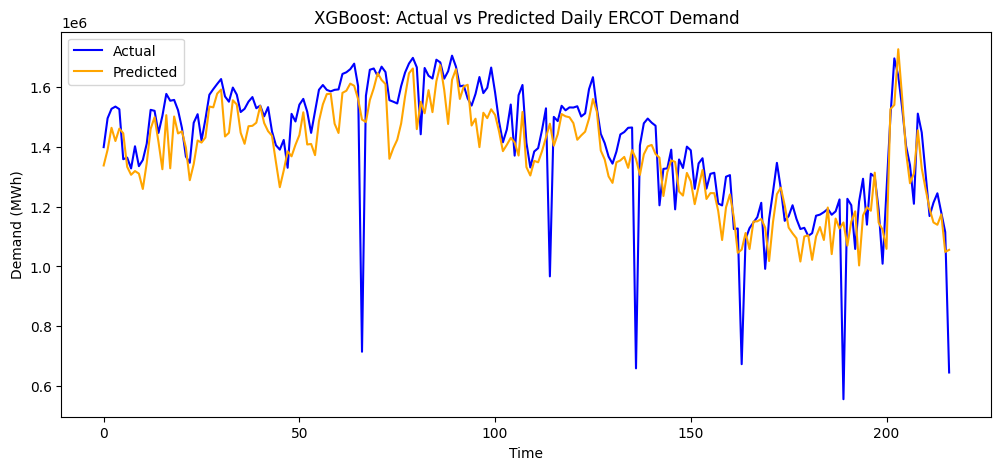

In [44]:
# Plot predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="orange")
plt.title("XGBoost: Actual vs Predicted Daily ERCOT Demand")
plt.xlabel("Time")
plt.ylabel("Demand (MWh)")
plt.legend()
plt.show()

Comparison from baseline model
| Metric | Linear Regression | XGBoost |
| ------ | ----------------- | ------- |
| MAE    | 100,260           | 88,465  |
| RMSE   | 141,422           | 130,193 |
| R²     | 0.537             | 0.608   |

- MAE decreased by ~12k MWh → smaller average error
- RMSE decreased by ~11k MWh → fewer large misses
- R^2 improved from 0.54 → 0.61 → explains more variance

### **Part 7: Feature engineer and improve XGBoost model**

In [46]:
# Add more lag features
for lag in range(1, 15):
    df[f'lag_{lag}'] = df['demand_mwh'].shift(lag)

# Add rolling averages (3-day and 7-day)
df['rolling_3'] = df['demand_mwh'].rolling(window=3).mean().shift(1)
df['rolling_7'] = df['demand_mwh'].rolling(window=7).mean().shift(1)

In [47]:
df = df.dropna().reset_index(drop=True)

In [48]:
# Define features, including the weather flags this time
wt_cols = ["WT01","WT02","WT03","WT04","WT05","WT06","WT07","WT08"]

features = [
    "TAVG", "TAVG_squared", "AWND", "PRCP", "month", "day_of_week"
] + [f'lag_{i}' for i in range(1,15)] + ['rolling_3', 'rolling_7'] + wt_cols

X = df[features]
y = df['demand_mwh']

In [49]:
# Time-based train/test split (80/20)
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [50]:
# XGBoost training
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [51]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost with extra lags, rolling averages, and weather types:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

XGBoost with extra lags, rolling averages, and weather types:
MAE: 85243.8515625
RMSE: 133680.19820452092
R2: 0.5912957191467285


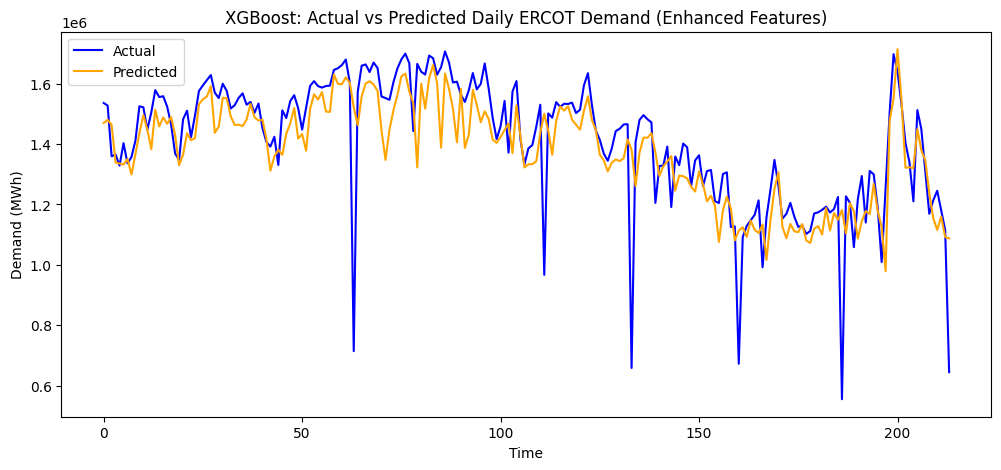

In [52]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="orange")
plt.title("XGBoost: Actual vs Predicted Daily ERCOT Demand (Enhanced Features)")
plt.xlabel("Time")
plt.ylabel("Demand (MWh)")
plt.legend()
plt.show()

| Model                             | MAE     | RMSE    | R²    |
| --------------------------------- | ------- | ------- | ----- |
| Baseline Linear Regression        | 100,260 | 141,422 | 0.537 |
| XGBoost (lag_1, lag_7)            | 88,465  | 130,193 | 0.608 |
| XGBoost + extra lags, rolling, WT | 85,244  | 133,680 | 0.591 |


The model captures small variations slightly better (MAE), but overall the added complexity did not improve overall variance explained. It's okay as sometimes simpler lag features capture the main patterns best.

### **Part 8: Try Prophet**

In [68]:
# Prepare the dataframe for Prophet
# Prophet expects columns: 'ds' = date, 'y' = target
prophet_df = df[['date', 'demand_mwh']].rename(columns={'date': 'ds', 'demand_mwh': 'y'})

In [69]:
# Initialize the model
# Daily seasonality is on by default; add yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='weekly', period=7, fourier_order=3)  # optional weekly seasonality

model.fit(prophet_df) # Fit model

23:27:53 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
# Make a future dataframe (forecast horizon = next 60 days)
future = model.make_future_dataframe(periods=60)  # 60 days into future
forecast = model.predict(future)

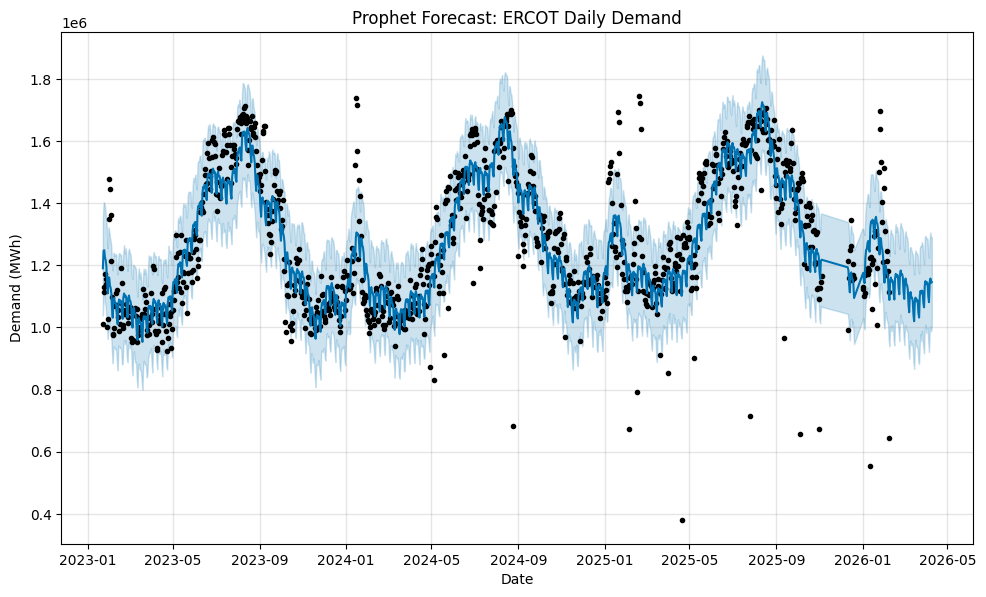

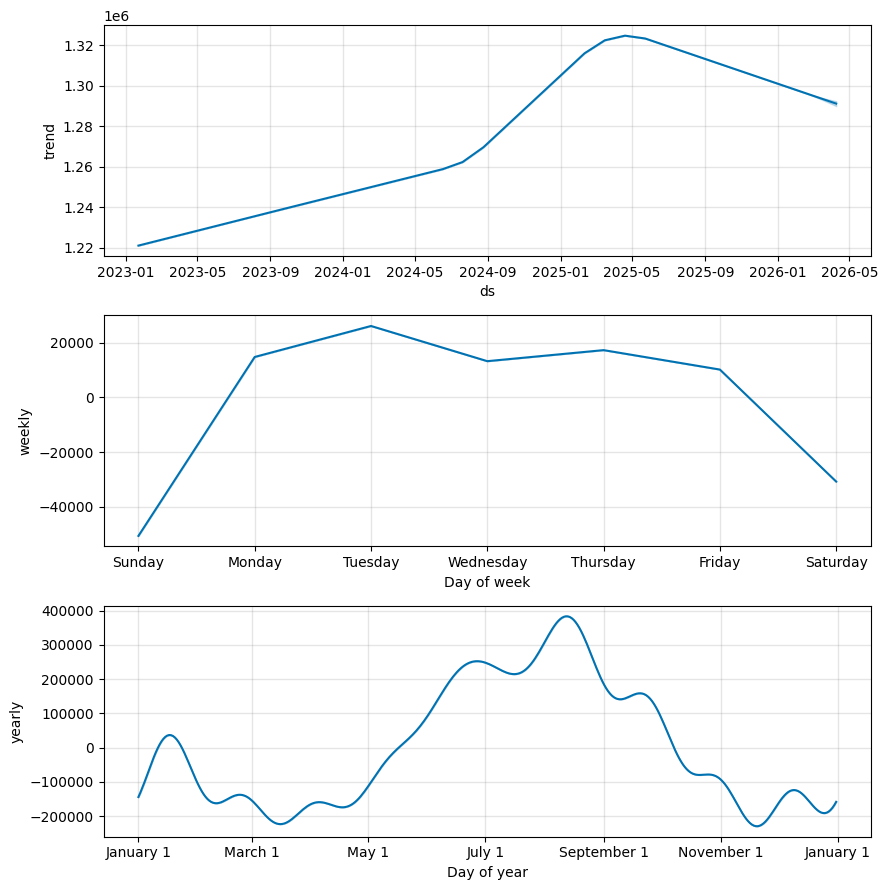

In [71]:
# Plot forecast
fig1 = model.plot(forecast)
plt.title("Prophet Forecast: ERCOT Daily Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MWh)")
plt.show()

# Plot components (trend + yearly + weekly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [72]:
# Align actuals with forecast
# Keep only the dates in the original dataset
forecast_subset = forecast[forecast['ds'].isin(prophet_df['ds'])]

y_true = prophet_df['y'].values
y_pred = forecast_subset['yhat'].values  # Prophet's predicted values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print("Prophet Model Metrics:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

Prophet Model Metrics:
MAE: 79436.04688426154
RMSE: 116622.9845608861
R²: 0.7168533451692733


| Model                            | MAE    | RMSE    | R²    |
| -------------------------------- | ------ | ------- | ----- |
| XGBoost (baseline)               | 88,465 | 130,193 | 0.608 |
| Prophet (no external regressors) | 79,436 | 116,623 | 0.717 |

- Lower MAE & RMSE: Prophet predicts daily ERCOT demand more accurately than XGBoost here.
- Higher R^2 (0.717): explains more of the variance in demand.
- Seasonality + trend decomposition: there's insight into weekly & yearly patterns, which is something XGBoost doesn’t explicitly show

Prophet highlights time-series behavior: seasonal peaks (summer heatwaves, winter spikes) and weekly trends. XGBoost is still useful for feature-driven modeling, showing how temperature & lags affect demand. For the dashboard we will show both -> one data-driven ML approach and one classic time-series approach with interpretable trends

### **Part 9: Extract data from final models (XGBoost baseline and Prophet)**

**Rerun XGBoost Baseline to extract data for dashboard -- reset kernel at this point because right now the df frame has lag features 1-14**

In [96]:
features = [
    "TAVG",
    "TAVG_squared",
    "AWND",
    "PRCP",
    "month",
    "day_of_week",
    "lag_1",
    "lag_7"]

X = df[features]
y = df["demand_mwh"]

# Time-based train/test split (80/20)
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [97]:
# XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,      # number of trees
    max_depth=5,           # tree depth
    learning_rate=0.05,    # shrinkage
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # column sampling
    random_state=42)

# Train and predict
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

XGBoost Results:
MAE: 88464.90625
RMSE: 130193.14734654815
R2: 0.6077686548233032


In [98]:
# Prepare XGBoost dashboard export
xgb_dashboard = pd.DataFrame({
    'date': df['date'].iloc[split_index:],           # test set dates
    'actual_demand_mwh': y_test.values,              # actual demand
    'predicted_demand_mwh': y_pred                  # XGBoost predictions
})

# Include key features if you want to show influence
xgb_dashboard['TAVG'] = X_test['TAVG'].values
xgb_dashboard['TAVG_squared'] = X_test['TAVG_squared'].values
xgb_dashboard['AWND'] = X_test['AWND'].values
xgb_dashboard['PRCP'] = X_test['PRCP'].values
xgb_dashboard['lag_1'] = X_test['lag_1'].values
xgb_dashboard['lag_7'] = X_test['lag_7'].values

# Save as CSV for Power BI
xgb_dashboard.to_csv("xgb_baseline_dashboard.csv", index=False)

print("XGBoost dashboard export ready with shape:", xgb_dashboard.shape)

XGBoost dashboard export ready with shape: (217, 9)


        feature  importance
6         lag_1    0.462815
1  TAVG_squared    0.242048
0          TAVG    0.171106
5   day_of_week    0.034261
7         lag_7    0.029855
3          PRCP    0.023896
4         month    0.020245
2          AWND    0.015773


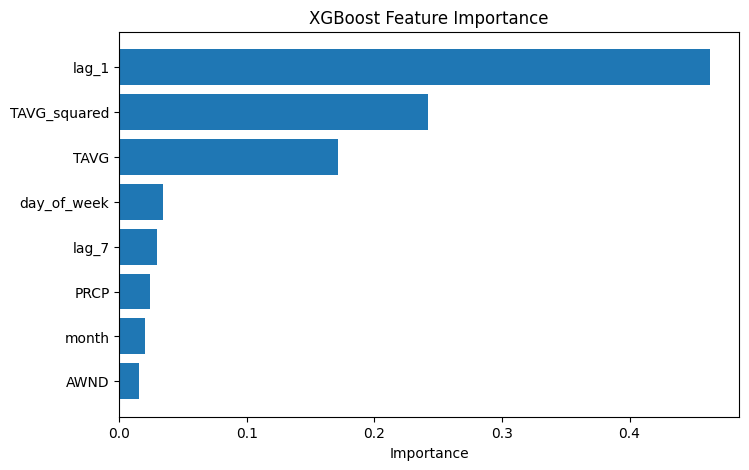

In [99]:
# Check feature importance
importance = xgb_model.feature_importances_

# Combine with feature names
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Export to CSV for Power BI
feature_importance.to_csv("xgb_feature_importance.csv", index=False)

print(feature_importance)

# Quick viz
plt.figure(figsize=(8,5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [100]:
# Export metrics
# Prepare metrics dataframe
metrics = pd.DataFrame({
    'model': ['XGBoost'],
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]})

metrics.to_csv("xgb_metrics.csv", index=False)
print(metrics)

     model          MAE           RMSE        R2
0  XGBoost  88464.90625  130193.147347  0.607769


**Rerun Prophet to extract data for dashboard**

In [102]:
# Prepare the dataframe for Prophet
# Prophet expects columns: 'ds' = date, 'y' = target
prophet_df = df[['date', 'demand_mwh']].rename(columns={'date': 'ds', 'demand_mwh': 'y'})

# Initialize the model
# Daily seasonality is on by default; add yearly seasonality
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='weekly', period=7, fourier_order=3)  # optional weekly seasonality

model.fit(prophet_df) # Fit model

# Make a future dataframe (forecast horizon = next 60 days)
future = model.make_future_dataframe(periods=60)  # 60 days into future
forecast = model.predict(future)

# Plot forecast
# fig1 = model.plot(forecast)
# plt.title("Prophet Forecast: ERCOT Daily Demand")
# plt.xlabel("Date")
# plt.ylabel("Demand (MWh)")
# plt.show()

# Plot components (trend + yearly + weekly seasonality)
# fig2 = model.plot_components(forecast)
# plt.show()

# Align actuals with forecast
# Keep only the dates in the original dataset
forecast_subset = forecast[forecast['ds'].isin(prophet_df['ds'])]

y_true = prophet_df['y'].values
y_pred = forecast_subset['yhat'].values  # Prophet's predicted values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print("Prophet Model Metrics:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Metrics:
MAE: 79432.75615623702
RMSE: 117496.84669701348
R²: 0.7151221392251903


In [103]:
# Prophet dashboard export
prophet_dashboard = pd.DataFrame({
    'date': forecast_subset['ds'],
    'actual_demand_mwh': y_true,
    'predicted_demand_mwh': y_pred,
    'trend': forecast_subset['trend'].values,
    'weekly': forecast_subset['weekly'].values,
    'yearly': forecast_subset['yearly'].values})

# Save to CSV for Power BI
prophet_dashboard.to_csv("prophet_dashboard.csv", index=False)
print("Prophet dashboard export ready with shape:", prophet_dashboard.shape)

# Prepare metrics dataframe
prophet_metrics = pd.DataFrame({
    'model': ['Prophet'],
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]})
# Save metrics CSV
prophet_metrics.to_csv("prophet_metrics.csv", index=False)
print(prophet_metrics)

Prophet dashboard export ready with shape: (1081, 6)
     model           MAE           RMSE        R2
0  Prophet  79432.756156  117496.846697  0.715122
